# VQE for Kagome Antiferromagnetic Heisenberg Model

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator, eigsh


In [2]:
# ======= COLORING SUBGRAPHS (논문 Fig.2 기반, 2x4 예시) =======
coloring_subgraphs = [
    [(0,1),(2,3),(4,5),(6,7)],        # subgraph 1: horizontal
    [(0,4),(1,5),(2,6),(3,7)],        # subgraph 2: vertical
    [(1,4),(2,5),(3,6)],              # subgraph 3: diagonal (예시, 실제 논문에 맞게 더 추가!)
    # subgraph 4, 5 필요하면 추가!
]


# 1. Define Kagome configuration

In [3]:
def kagome_patch(rows, cols):
    coords = {}
    edges = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            coords[idx] = (c, r)
    for r in range(rows):
        for c in range(cols - 1):
            i = r * cols + c
            j = i + 1
            edges.append((i, j))
    for r in range(rows - 1):
        for c in range(cols - 1):
            a = r * cols + c + 1
            b = (r + 1) * cols + c
            edges.append((a, b))
    for r in range(rows - 1):
        for c in range(cols - 1):
            a = r * cols + c
            b = (r + 1) * cols + c + 1
            edges.append((a, b))
    return edges, coords

def initial_matching():
    return [(0,1),(2,3),(4,5),(6,7)]  # for 2x4

# 2. Prepare initial state

In [4]:
def prepare_singlet_state(num_qubits, matching):
    qc = QuantumCircuit(num_qubits)
    for k, l in matching:
        qc.h(k)
        qc.cx(k, l)
        qc.x(l)
        qc.z(k)
    return qc

def prepare_spin_flip_state(num_qubits, matching):
    qc = QuantumCircuit(num_qubits)
    for k, l in matching:
        qc.h(k)
        qc.cx(k, l)
        qc.x(l)
        qc.z(k)
    qc.x(0)
    return qc

# 3. Define Hamiltonian

In [5]:
def build_hamiltonian(num_qubits, edges):
    paulis = []
    for i, j in edges:
        for term in ('XX','YY','ZZ'):
            label = ['I'] * num_qubits
            label[i], label[j] = term[0], term[1]
            paulis.append((''.join(label), 1.0))
    return SparsePauliOp.from_list(paulis, num_qubits=num_qubits)


# 4. Build ansatz families

In [6]:
# ======= ANSATZ FAMILIES =======

def per_hamiltonian_ansatz(layers):
    # shared param for H0, shared param for H
    rows, cols = 2, 4
    num_qubits = rows * cols
    edges, _ = kagome_patch(rows, cols)
    H0_edges = initial_matching()
    theta_params = ParameterVector('theta', 2*layers)
    qc = QuantumCircuit(num_qubits)
    qc.compose(prepare_singlet_state(num_qubits, H0_edges), inplace=True)
    for l in range(layers):
        theta0 = theta_params[2*l]
        for (k, m) in H0_edges:
            qc.rxx(2*theta0, k, m)
            qc.ryy(2*theta0, k, m)
            qc.rzz(2*theta0, k, m)
        theta1 = theta_params[2*l+1]
        for (i, j) in edges:
            qc.rxx(2*theta1, i, j)
            qc.ryy(2*theta1, i, j)
            qc.rzz(2*theta1, i, j)
    return qc, theta_params

def per_edge_ansatz(layers):
    # every edge, every layer has its own parameter
    rows, cols = 2, 4
    num_qubits = rows * cols
    edges, _ = kagome_patch(rows, cols)
    H0_edges = initial_matching()
    total_params = layers * (1 + len(edges))
    theta_params = ParameterVector('theta', total_params)
    qc = QuantumCircuit(num_qubits)
    qc.compose(prepare_singlet_state(num_qubits, H0_edges), inplace=True)
    idx = 0
    for _ in range(layers):
        theta0 = theta_params[idx]
        for (k, l) in H0_edges:
            qc.rxx(2*theta0, k, l)
            qc.ryy(2*theta0, k, l)
            qc.rzz(2*theta0, k, l)
        idx += 1
        for (i, j) in edges:
            theta_e = theta_params[idx]
            qc.rxx(2*theta_e, i, j)
            qc.ryy(2*theta_e, i, j)
            qc.rzz(2*theta_e, i, j)
            idx += 1
    return qc, theta_params

def per_edge_color_ansatz(layers):
    # Each coloring (subgraph) has one shared parameter per layer
    rows, cols = 2, 4
    num_qubits = rows * cols
    num_colors = len(coloring_subgraphs)
    theta_params = ParameterVector('theta', layers * num_colors)
    qc = QuantumCircuit(num_qubits)
    qc.compose(prepare_singlet_state(num_qubits, initial_matching()), inplace=True)
    for l in range(layers):
        for c, subg in enumerate(coloring_subgraphs):
            theta = theta_params[l*num_colors + c]
            for (i, j) in subg:
                qc.rxx(2*theta, i, j)
                qc.ryy(2*theta, i, j)
                qc.rzz(2*theta, i, j)
    return qc, theta_params

def per_edge_color_ii_ansatz(layers):
    # 보조자료의 또다른 coloring, 예시로 위와 동일하게 둠
    return per_edge_color_ansatz(layers)

# 5. Find ground state

In [7]:
# ======= VQE, MEASUREMENT, ETC. =======

def expectation(theta_params, ansatz, H_op):
    param_dict = dict(zip(ansatz.parameters, theta_params))
    qc_assigned = ansatz.assign_parameters(param_dict)
    sv = Statevector.from_instruction(qc_assigned)
    expval = 0.0
    for label, coeff in H_op.to_list():
        expval += coeff * sv.expectation_value(Pauli(label))
    return float(np.real(expval))

def exact_ground_state(num_qubits, edges):
    H_op = build_hamiltonian(num_qubits, edges)
    dim = 2**num_qubits
    term_list = H_op.to_list()
    def apply_pauli(label: str, v: np.ndarray) -> np.ndarray:
        n = len(label)
        out = np.zeros_like(v)
        N = v.size
        for idx in range(N):
            amp = v[idx]
            phase = 1
            flipped = idx
            for q in range(n):
                p = label[n-1-q]
                bit = (idx >> q) & 1
                if p == 'I':
                    continue
                elif p == 'X':
                    flipped ^= (1 << q)
                elif p == 'Y':
                    phase *= (1j if bit == 0 else -1j)
                    flipped ^= (1 << q)
                elif p == 'Z':
                    if bit == 1:
                        phase *= -1
                else:
                    raise ValueError(f"Unknown Pauli {p}")
            out[flipped] += phase * amp
        return out
    def mv(v):
        out = np.zeros_like(v)
        for label, c in term_list:
            out += c * apply_pauli(label, v)
        return out
    H_linop = LinearOperator((dim, dim), matvec=mv, dtype=complex)
    vals, vecs = eigsh(H_linop, k=1, which='SA')
    return vecs[:, 0]

## Run

In [ ]:
QiskitRuntimeService.save_account(
    channel='ibm_cloud',
    token='fQZ9Od-7ELw2Hx8N6TssYIZGdX7sbRYf6zkj08tlJrDI'
    instance=''
    overwrite= True
)

service = QiskitRuntimeService()
print(service.backends())

TypeError: Estimator.__init__() takes 1 positional argument but 2 were given

***

## Reproduce Fig. 5

In [8]:
def infidelity(psi_vqe, psi_exact):
    ov = np.vdot(psi_exact, psi_vqe)
    return 1 - abs(ov)**2

def get_statevector(ansatz, params):
    param_dict = dict(zip(ansatz.parameters, params))
    qc_assigned = ansatz.assign_parameters(param_dict)
    sv = Statevector.from_instruction(qc_assigned)
    return sv.data

In [9]:
def run_vqe(num_qubits, edges, layers, factory, sector='singlet'):
    H = build_hamiltonian(num_qubits, edges)
    ansatz, theta_params = factory(layers)
    init_params = np.random.uniform(0, 2*np.pi, len(theta_params))
    res = minimize(lambda x: expectation(x, ansatz, H), init_params, method='COBYLA', options={'maxiter':100})
    return res.fun, res.x

def compute_spin_gap(num_qubits, edges, layers, factory):
    H = build_hamiltonian(num_qubits, edges)
    ansatz_singlet, params_singlet = factory(layers)
    init_s = np.random.uniform(0, 2*np.pi, len(params_singlet))
    res_s = minimize(lambda x: expectation(x, ansatz_singlet, H), init_s, method='COBYLA', options={'maxiter':100})
    E0 = res_s.fun
    ansatz_sz1, params_sz1 = per_edge_ansatz(layers)
    init_1 = np.random.uniform(0, 2*np.pi, len(params_sz1))
    res_1 = minimize(lambda x: expectation(x, ansatz_sz1, H), init_1, method='COBYLA', options={'maxiter':100})
    E1 = res_1.fun
    return E1 - E0

In [10]:
def reproduce_fig5(layers_max=2, seeds=2):
    rows, cols = 2, 4
    num_qubits = rows * cols
    edges, _ = kagome_patch(rows, cols)
    psi0 = exact_ground_state(num_qubits, edges)
    factories = {
        'per hamiltonian': per_hamiltonian_ansatz,
        'per edge color': per_edge_color_ansatz,
        'per edge color ii': per_edge_color_ii_ansatz,
        'per edge': per_edge_ansatz
    }
    results = {name: {'p': [], 'mean': [], 'std': []} for name in factories}
    H = build_hamiltonian(num_qubits, edges)
    for name, factory in factories.items():
        for p in range(1, layers_max+1):
            vals = []
            for seed in range(seeds):
                np.random.seed(seed)
                qc, params = factory(p)
                init = np.random.uniform(0, 1/p, len(params))
                res = minimize(lambda x: expectation(x, qc, H), init, method='COBYLA', options={'maxiter':100})
                psi_vqe = get_statevector(qc, res.x)
                vals.append(infidelity(psi_vqe, psi0))
            results[name]['p'].append(p)
            results[name]['mean'].append(np.mean(vals))
            results[name]['std'].append(np.std(vals))
    markers = {'per hamiltonian':'D','per edge color':'o','per edge color ii':'v','per edge':'s'}
    colors = {'per hamiltonian':'tab:blue','per edge color':'tab:orange','per edge color ii':'tab:green','per edge':'tab:red'}
    plt.figure()
    for name, data in results.items():
        if not data['p'] or all([np.isnan(m) or m == 0 for m in data['mean']]):
            continue
        plt.errorbar(data['p'], data['mean'], yerr=data['std'], label=name,
            marker=markers.get(name,'o'), color=colors.get(name,None),
            capsize=4, linestyle='-')
    plt.yscale('log')
    plt.xlabel('HV layers p')
    plt.ylabel('Infidelity')
    plt.legend()
    plt.title('Fig.5 reproduction: 2x4 Kagome patch')
    plt.tight_layout()
    plt.show()

In [11]:
def reproduce_fig6(layers_max=2, seeds=2):
    rows, cols = 2, 4
    num_qubits = rows * cols
    edges, _ = kagome_patch(rows, cols)
    factories = {
        'per hamiltonian': per_hamiltonian_ansatz,
        'per edge color': per_edge_color_ansatz,
        'per edge color ii': per_edge_color_ii_ansatz,
        'per edge': per_edge_ansatz
    }
    results = {name: {'p': [], 'mean': [], 'std': []} for name in factories}
    for name, factory in factories.items():
        for p in range(1, layers_max+1):
            vals = []
            for seed in range(seeds):
                np.random.seed(seed)
                gap = compute_spin_gap(num_qubits, edges, p, factory)
                vals.append(gap)
            results[name]['p'].append(p)
            results[name]['mean'].append(np.mean(vals))
            results[name]['std'].append(np.std(vals))
    plt.figure()
    for name, data in results.items():
        plt.errorbar(data['p'], data['mean'], yerr=data['std'], label=name)
    plt.xlabel('HV layers p')
    plt.ylabel('Spin gap')
    plt.legend()
    plt.title('Fig.6 reproduction: 2x4 Kagome patch')
    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/qiskit/lib/python3.11/site-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 106
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


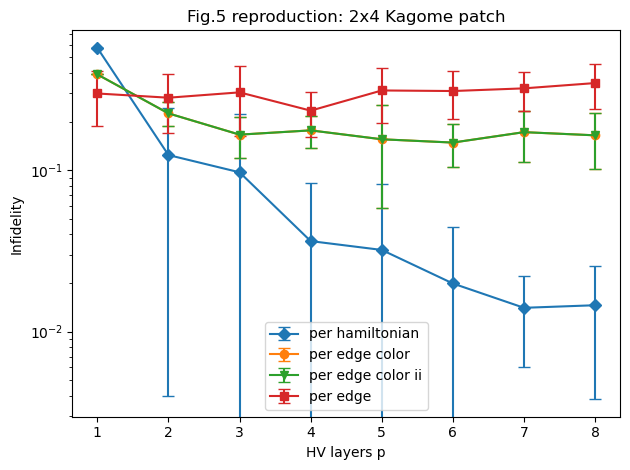

In [12]:
reproduce_fig5(layers_max=8, seeds=10)